# Importing Data

In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import collections
import random
from sklearn.metrics import f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import tree, svm

#data import
#taken from Reddit discussion: https://www.reddit.com/r/McGill_comp551s1/comments/7x2sdy/assignment3/
yelp_train = pd.read_csv('Datasets/yelp-train.txt',sep='\t',names=["Comment", "Evaluation"])
yelp_test = pd.read_csv('Datasets/yelp-test.txt',sep='\t',names=["Comment", "Evaluation"])
yelp_valid = pd.read_csv('Datasets/yelp-valid.txt',sep='\t',names=["Comment", "Evaluation"])
imdb_train = pd.read_csv('Datasets/IMDB-train.txt',sep='\t',names=["Comment", "Evaluation"])
imdb_test =  pd.read_csv('Datasets/IMDB-test.txt',sep='\t',names=["Comment", "Evaluation"])
imdb_valid =  pd.read_csv('Datasets/IMDB-valid.txt',sep='\t',names=["Comment", "Evaluation"])

In [46]:
#data clean up
def pre_process(review):
    #we remove the breaks from the dataset
    review = re.sub('<br /><br />', '', review)
    return re.sub(r'[^a-zA-Z ]', '', review).lower()

#remove all punctuation and put to lower case
for i, row in yelp_train.iterrows():
    yelp_train.set_value(i,'Comment',pre_process(row['Comment']))
for i, row in imdb_train.iterrows():
    imdb_train.set_value(i,'Comment',pre_process(row['Comment']))

In [47]:
def get_vocabulary(training_set):
    # Now go through and find the frequency of each word
    unsorted_vocabulary = {}

    #populate the unsorted vocab
    for review in training_set['Comment']:
        #filter removes the blank spaces
        for word in filter(None, review.split(' ')):
            if(word in unsorted_vocabulary):
                    unsorted_vocabulary[word] += 1
            else:
                unsorted_vocabulary[word] = 1

    #now we will create a sorted vocab of the top 10000 words
    return collections.Counter(unsorted_vocabulary).most_common(10000)

## Vector generating methods (binary and frequency bag of words)

In [48]:
def generate_bbow_vector(words, sentence):
    sentence = pre_process(sentence)
    vector = np.zeros(10000)
    for word in filter(None, sentence.split(' ')):
        if(word in words):
            vector[words.index(word)] = 1
    return vector

def generate_freq_vector(words, sentence):
    sentence = pre_process(sentence)
    vector = np.zeros(10000)
    total_words_in_vocab = 0
    for word in filter(None, sentence.split(' ')):
        if(word in words):
            total_words_in_vocab += 1.
            vector[words.index(word)] += 1.
    for i in range(0, len(vector)):
        if(total_words_in_vocab != 0):
            vector[i] = vector[i] / total_words_in_vocab
    return vector

In [49]:
yelp_vocabulary = get_vocabulary(yelp_train)
yelp_words = [i[0] for i in yelp_vocabulary]

imdb_vocabulary = get_vocabulary(imdb_train)
imdb_words = [i[0] for i in imdb_vocabulary]

# print(generate_bbow_vector(yelp_words, "willow and of the"))
# print(generate_freq_vector(yelp_words, "willow asdlkfjalsdfk and and of the"))
# print(generate_bbow_vector(imdb_words, "willow and of the"))
# print(generate_freq_vector(imdb_words, "willow asdlkfjalsdfk and and of the"))

In [50]:
# Now we will create the IMDB and YELP datasets, as described in the report handout
def create_vocab_file(vocabulary, filename):
    word_count = 1
    with open(filename, 'w') as the_file:
        for i, item in vocabulary:
            the_file.write(str(word_count) + "\t" + str(i) + "\t" + str(item) + "\n")
            word_count +=1

create_vocab_file(yelp_vocabulary, "Datasets/yelp-vocab.txt")
create_vocab_file(imdb_vocabulary, "Datasets/IMDB-vocab.txt")

# Random classifier

In [51]:
#From here on in, we will be actually training and testing

# this method will take in a bunch of data and calculate F1
def random_classifier(train_data, test_data, min_class, max_class):
    test_prediction = []
    train_prediction = []
    
    # go through data and choose a random class
    for i in range(0, len(train_data)):
        class_predict = random.randint(min_class, max_class)
        train_prediction.append(class_predict)
    for i in range(0, len(test_data)):
        class_predict = random.randint(min_class, max_class)
        test_prediction.append(class_predict)
    return train_prediction, test_prediction


In [52]:
#Yelp Random
yelp_random_train_predict, yelp_random_test_predict = random_classifier(yelp_train, yelp_test, 1, 5)
yelp_rand_train_f1 = f1_score(yelp_train['Evaluation'], yelp_random_train_predict, average='micro')
yelp_rand_test_f1 = f1_score(yelp_test['Evaluation'], yelp_random_test_predict, average='micro')

print("Train f1 is " + str(yelp_rand_train_f1) + ", Test F1 is " + str(yelp_rand_test_f1))

Train f1 is 0.200285714286, Test F1 is 0.2055


In [53]:
#IMDB Random

imdb_random_train_predict, imdb_random_test_predict = random_classifier(imdb_train, imdb_test, 0,1)
imdb_rand_train_f1 = f1_score(imdb_train['Evaluation'], imdb_random_train_predict)
imdb_rand_test_f1 = f1_score(imdb_test['Evaluation'], imdb_random_test_predict)


print("Train f1 is " + str(imdb_rand_train_f1) + ", Test F1 is " + str(imdb_rand_test_f1))

Train f1 is 0.504853078048, Test F1 is 0.495889641898


# Majority Classifier

In [54]:
def majority_classifier(train_data, test_data):
    train_mode = train_data['Evaluation'].mode()[0]
    test_mode = test_data['Evaluation'].mode()[0]
    
    train_prediction = [train_mode] * len(train_data)
    test_prediction = [test_mode] * len(test_data)
    return train_prediction, test_prediction

In [55]:
#Yelp Majority Classifier
yelp_maj_train_predict, yelp_maj_test_predict = majority_classifier(yelp_train, yelp_test)
yelp_rand_train_f1 = f1_score(yelp_train['Evaluation'], yelp_maj_train_predict, average='micro')
yelp_rand_test_f1 = f1_score(yelp_test['Evaluation'], yelp_maj_test_predict, average='micro')

print("Train f1 is " + str(yelp_rand_train_f1) + ", Test F1 is " + str(yelp_rand_test_f1))

Train f1 is 0.352571428571, Test F1 is 0.351


In [56]:
#IMDB Majority Classifier
imdb_maj_train_predict, imdb_maj_test_predict = majority_classifier(imdb_train, imdb_test)
imdb_rand_train_f1 = accuracy_score(imdb_train['Evaluation'], imdb_maj_train_predict)
imdb_rand_test_f1 = accuracy_score(imdb_test['Evaluation'], imdb_maj_test_predict)

print("Train accuracy is " + str(imdb_rand_train_f1) + ", Test accuracy is " + str(imdb_rand_test_f1))

Train accuracy is 0.5, Test accuracy is 0.5


# Creating Data matrices

In [58]:
#first make the training features matrix
yelp_training_inputs = [[] for i in range(2)]
yelp_testing_inputs = [[] for i in range(2)]
yelp_validation_inputs = [[] for i in range(2)]

#first do yelp
for sentence in yelp_train['Comment']:
    yelp_training_inputs[0].append(generate_bbow_vector(yelp_words, sentence))
    yelp_training_inputs[1].append(generate_freq_vector(yelp_words, sentence))

for sentence in yelp_test['Comment']:
    yelp_testing_inputs[0].append(generate_bbow_vector(yelp_words, sentence))
    yelp_testing_inputs[1].append(generate_freq_vector(yelp_words, sentence))

for sentence in yelp_valid['Comment']:
    yelp_validation_inputs[0].append(generate_bbow_vector(yelp_words, sentence))
    yelp_validation_inputs[1].append(generate_bbow_vector(yelp_words, sentence))#Get all of the inputs for IMDB, too.


In [59]:
#now do the same for IMDB
imdb_training_inputs = [[] for i in range(2)]
imdb_testing_inputs = [[] for i in range(2)]
imdb_validation_inputs = [[] for i in range(2)]

# we will separate into different jupyter blocks to save debugging time
for sentence in imdb_train['Comment']:
    imdb_training_inputs[0].append(generate_bbow_vector(imdb_words, sentence))
    imdb_training_inputs[1].append(generate_freq_vector(imdb_words, sentence))

In [60]:
#test
for sentence in imdb_test['Comment']:
    imdb_testing_inputs[0].append(generate_bbow_vector(imdb_words, sentence))
    imdb_testing_inputs[1].append(generate_freq_vector(imdb_words, sentence))

In [61]:
#validation
for sentence in imdb_valid['Comment']:
    imdb_validation_inputs[0].append(generate_bbow_vector(imdb_words, sentence))
    imdb_validation_inputs[1].append(generate_bbow_vector(imdb_words, sentence))

# Running Classifiers with default hyperparameters

In [62]:
def run_classifier(classifier, train_input, train_target, valid_input, valid_target, test_input, test_target):
    classifier.fit(train_input, train_target)
    train_target_pred = classifier.predict(train_input)
    valid_target_pred = classifier.predict(valid_input)
    test_target_pred = classifier.predict(test_input)

    train_f1 = f1_score(train_target, train_target_pred, average='micro')
    valid_f1 = f1_score(valid_target, valid_target_pred, average='micro')
    test_f1 = f1_score(test_target, test_target_pred, average='micro')
    return train_f1, valid_f1, test_f1

In [63]:
def run_yelp_classifiers(classifiers, data_index):
    #run it on each classifier and print the results (BBOW)
    for classifier in classifiers:
        metrics = run_classifier(classifier[1], yelp_training_inputs[data_index],   yelp_train['Evaluation'], 
                                                yelp_validation_inputs[data_index], yelp_valid['Evaluation'], 
                                                yelp_testing_inputs[data_index],    yelp_test['Evaluation'])
        print(str(classifier[0]) + str(metrics))

def run_imdb_classifiers(classifiers, data_index):
    #run it on each classifier and print the results (BBOW)
    for classifier in classifiers:
        metrics = run_classifier(classifier[1], imdb_training_inputs[data_index],   imdb_train['Evaluation'], 
                                                imdb_validation_inputs[data_index], imdb_valid['Evaluation'], 
                                                imdb_testing_inputs[data_index],    imdb_test['Evaluation'])
        print(str(classifier[0]) + str(metrics))

In [64]:
#Create the classifiers we want to use to train and test our data
classifiers = []
#We use bernoulli here since, with the binary bag of words, the features are binary.
classifiers.append(("Bernoulli Naive Bayes: ", BernoulliNB()))
classifiers.append(("Decision Trees: ", tree.DecisionTreeClassifier()))
classifiers.append(("SVM: ", svm.LinearSVC()))

#run the classifiers for BBOW (data_index = 0)
run_yelp_classifiers(classifiers, 0)

Bernoulli Naive Bayes: (0.59771428571428575, 0.38100000000000001, 0.40949999999999998)
Decision Trees: (1.0, 0.33200000000000002, 0.34300000000000003)
SVM: (0.998, 0.441, 0.44900000000000001)


In [65]:
#We will now alter our classifiers list for the frequency representation
classifiers[0] = ("Gaussian Naive Bayes: ", GaussianNB())
# Now we rerun with data_index = 1 (Frequency data)
run_yelp_classifiers(classifiers, 1)

Gaussian Naive Bayes: (0.8025714285714286, 0.36799999999999999, 0.31)
Decision Trees: (1.0, 0.309, 0.36699999999999999)
SVM: (0.50257142857142856, 0.44400000000000001, 0.46200000000000002)


In [66]:
#now we will repeat with IMDB...
classifiers[0] = ("Bernoulli Naive Bayes: ", BernoulliNB())
run_imdb_classifiers(classifiers, 0)

Bernoulli Naive Bayes: (0.86839999999999995, 0.84099999999999997, 0.83132000000000006)
Decision Trees: (1.0, 0.6966, 0.69855999999999996)
SVM: (1.0, 0.84190000000000009, 0.82979999999999998)


In [67]:
#We will now alter our classifiers list for the frequency representation
classifiers[0] = ("Gaussian Naive Bayes: ", GaussianNB())
# Now we rerun with data_index = 1 (Frequency data)
run_imdb_classifiers(classifiers, 1)

Gaussian Naive Bayes: (0.86113333333333331, 0.76629999999999998, 0.68759999999999999)
Decision Trees: (1.0, 0.54390000000000005, 0.69284000000000001)
SVM: (0.80620000000000003, 0.80200000000000005, 0.79100000000000004)


# Cross-Validation Methods

In [93]:
#Now we will do some tuning of hyperparameters. First we need a method that returns the accuracy of a validation set.
def run_classifier_validation(classifier, train_input, train_target, valid_input, valid_target):
    classifier.fit(train_input, train_target)
    valid_target_pred = classifier.predict(valid_input)
    return f1_score(valid_target, valid_target_pred, average='micro')

#now we will run this on different hyperparameters and see what the best values to choose are.

In [107]:
def validate_bernoulli(train_input, train_target, valid_input, valid_target):
    f1_scores = []
    max_f1 = 0
    best_alpha = 0
    alpha_values = []
    #for exp in range(-5, 1):
    for exp in range(-1,1):
        #for i in range(1, 10):
        for i in range(1, 10, 2):
            alpha_values.append(i*10**exp)

    for alpha in alpha_values:
        classifier = BernoulliNB(alpha=alpha)
        score = run_classifier_validation(classifier, train_input, train_target, valid_input, valid_target)
        f1_scores.append(score)
        if(score > max_f1):
            max_f1 = score
            best_alpha = alpha
        #print(str(alpha) + ", " + str(score))
    print("The best validation f1 happens when alpha = " + str(best_alpha) + " and is " + str(max_f1))
    plt.plot(alpha_values, f1_scores, 'ro')
    plt.ylabel('F1 Measure')
    plt.show()
    return best_alpha

def validate_decision_tree(train_input, train_target, valid_input, valid_target):
    # Next we will do decision trees
    f1_scores = []
    max_f1 = 0
    best_param = 0
    #depth_values = [1,2,5,10,20,50, 100, 1000, 5000, 10000, 20000, None]
    depth_values = [1,10,100,5000, None]
    
    for param in depth_values:
        classifier =tree.DecisionTreeClassifier(max_depth=param)
        score = run_classifier_validation(classifier, train_input, train_target, valid_input, valid_target)
                                                    
        f1_scores.append(score)
        if(score > max_f1):
            max_f1 = score
            best_param = param
        #print(str(param) + ", " + str(score))
    print("The best validation f1 happens when max_depth = " + str(best_param) + " and is " + str(max_f1))
    plt.plot(depth_values[:-1], f1_scores[:-1])
    plt.ylabel('F1 Measure')
    plt.show()
    return best_param

def validate_SVM(train_input, train_target, valid_input, valid_target):
    # Next we will do decision trees
    f1_scores = []
    max_f1 = 0
    best_tol = 0
    best_max_iter = 0
    best_c = 0
    tols = []
    #for exp in range(-6, -4):
    #    for i in range(1, 10, 4):
    #        tols.append(i*10**exp)
    tols.append(10**(-5))
    max_iters = (1, 2, 5, 10)

    cs = []
    for exp in range(-1, 1):
        for i in range(1, 10,2):
            cs.append(i*10**exp)

    for max_iter in max_iters:
        for c in cs:
            for tol in tols:
                classifier = svm.LinearSVC(tol=tol, C=c, max_iter=max_iter)
                score = run_classifier_validation(classifier, train_input, train_target, valid_input, valid_target)
                f1_scores.append(score)
                if(score > max_f1):
                    max_f1 = score
                    best_tol= tol
                    best_max_iter = max_iter
                    best_c = c
    print("The best validation f1 happens when params = " + str((best_tol, best_max_iter, best_c)) + " and is " + str(max_f1))
    return best_tol, best_max_iter, best_c

# Yelp Classifiers

### Binary Bag of Words

The best validation f1 happens when alpha = 0.1 and is 0.407


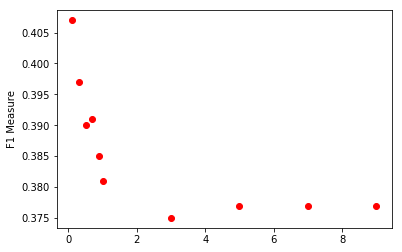

In [109]:
#first we will do Bernoulli (YELP) BBOW
best_yelp_classifiers = []
alpha = validate_bernoulli(yelp_training_inputs[0], yelp_train['Evaluation'], yelp_validation_inputs[0], yelp_valid['Evaluation'])
best_yelp_classifiers.append(("Bernoulli Naive Bayes: ", BernoulliNB(alpha=alpha)))

The best validation f1 happens when max_depth = 10 and is 0.39


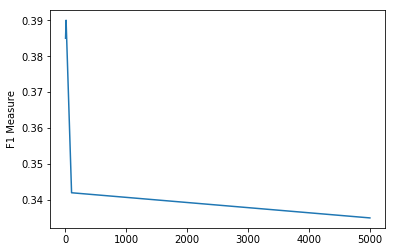

In [110]:
#perform validation with Decision tree (YELP) on BBOW
max_depth = validate_decision_tree(yelp_training_inputs[0], yelp_train['Evaluation'],yelp_validation_inputs[0], yelp_valid['Evaluation'])
best_yelp_classifiers.append(("Decision Trees: ", tree.DecisionTreeClassifier(max_depth=max_depth)))

In [111]:
#Perform validation on SVM (YELP) BBOW
tol, max_iter, c = validate_SVM(yelp_training_inputs[0], yelp_train['Evaluation'], yelp_validation_inputs[0], yelp_valid['Evaluation'])
best_yelp_classifiers.append(("SVM: ", svm.LinearSVC(tol=tol, max_iter=max_iter, C=c)))

The best validation f1 happens when params = (1e-05, 10, 0.30000000000000004) and is 0.477


In [112]:
#run the classifiers for BBOW (data_index = 0)
run_yelp_classifiers(best_yelp_classifiers, 0)

Bernoulli Naive Bayes: (0.70685714285714285, 0.40700000000000003, 0.439)
Decision Trees: (0.5288571428571428, 0.38700000000000001, 0.39400000000000002)
SVM: (0.96885714285714286, 0.45500000000000002, 0.46300000000000002)


### Frequency Bag of Words

The best validation f1 happens when max_depth = 1 and is 0.385


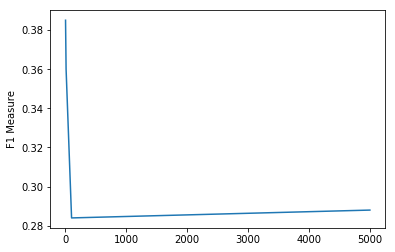

In [113]:
best_yelp_classifiers = []
#Now we are going to do the same thing but with the frequency inputs
#We don't do any NB parameter tuning since nothing to tune for GaussianNB
#perform validation with Decision tree (YELP) on FREQ
max_depth = validate_decision_tree(yelp_training_inputs[1], yelp_train['Evaluation'],yelp_validation_inputs[1], yelp_valid['Evaluation'])
best_yelp_classifiers.append(("Decision Trees: ", tree.DecisionTreeClassifier(max_depth=max_depth)))

In [114]:
#Perform validation on SVM (YELP) FREQ
tol, max_iter, c = validate_SVM(yelp_training_inputs[1], yelp_train['Evaluation'], yelp_validation_inputs[1], yelp_valid['Evaluation'])
best_yelp_classifiers.append(("SVM: ", svm.LinearSVC(tol=tol, max_iter=max_iter, C=c)))

The best validation f1 happens when params = (1e-05, 10, 7) and is 0.459


In [115]:
#run the classifiers for FREQ (data_index = 1)
run_yelp_classifiers(best_yelp_classifiers, 1)

Decision Trees: (0.39642857142857141, 0.38499999999999995, 0.38499999999999995)
SVM: (0.38785714285714284, 0.45900000000000002, 0.36499999999999994)


# IMDB Classifiers

### Binary Bag of Words

In [ ]:
#now we have to do the same validation for IMDB.
best_imdb_classifiers = []
#first we will do Bernoulli (IMDB) BBOW
alpha = validate_bernoulli(imdb_training_inputs[0], imdb_train['Evaluation'], imdb_validation_inputs[0], imdb_valid['Evaluation'])
best_imdb_classifiers.append(("Bernoulli Naive Bayes: ", BernoulliNB(alpha=alpha)))

In [ ]:
#perform validation with Decision tree (IMDB) on BBOW
max_depth = validate_decision_tree(imdb_training_inputs[0], imdb_train['Evaluation'],imdb_validation_inputs[0], imdb_valid['Evaluation'])
best_imdb_classifiers.append(("Decision Trees: ", tree.DecisionTreeClassifier(max_depth=max_depth)))

In [ ]:
#Perform validation on SVM (imdb) BBOW
tol, max_iter, c = validate_SVM(imdb_training_inputs[0], imdb_train['Evaluation'], imdb_validation_inputs[0], imdb_valid['Evaluation'])
best_imdb_classifiers.append(("SVM: ", svm.LinearSVC(tol=tol, max_iter=max_iter, C=c)))

In [ ]:
#run the classifiers for BBOW (data_index = 0)
run_imdb_classifiers(best_imdb_classifiers, 0)

### Frequency Bag of Words

In [ ]:
best_imdb_classifiers = []
#Now we are going to do the same thing but with the frequency inputs
#We don't do any NB parameter tuning since nothing to tune for GaussianNB
#perform validation with Decision tree (imdb) on FREQ
max_depth = validate_decision_tree(imdb_training_inputs[1], imdb_train['Evaluation'],imdb_validation_inputs[1], imdb_valid['Evaluation'])
best_imdb_classifiers.append(("Decision Trees: ", tree.DecisionTreeClassifier(max_depth=max_depth)))

In [ ]:
#Perform validation on SVM (YELP) FREQ
tol, max_iter, c = validate_SVM(imdb_training_inputs[1], imdb_train['Evaluation'], imdb_validation_inputs[1], imdb_valid['Evaluation'])
best_imdb_classifiers.append(("SVM: ", svm.LinearSVC(tol=tol, max_iter=max_iter, C=c)))